In [7]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, print_progress, read_mnist_data, add_variable_histogram_summaries, merge, interpolate
from os.path import exists
from glob import glob
import scipy

In [8]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


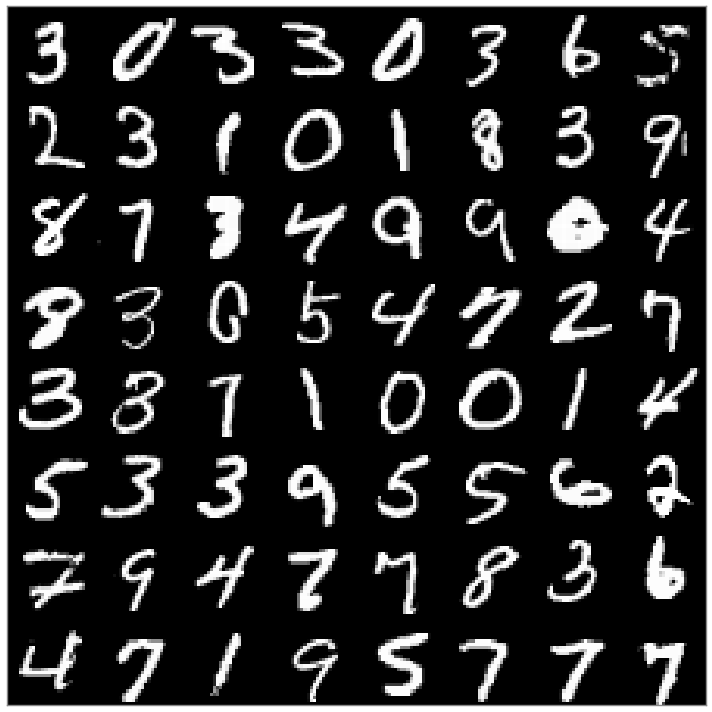

In [3]:
plot_images(merge(data.train.next_batch(64)[0]))

In [9]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [10]:
def generator(z, c, training):
    x_gen = tf.layers.dense(tf.concat([z, c], 1), 7 * 7 * 256, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    x_gen = tf.reshape(x_gen, (-1, 7, 7, 256))
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 128, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv1')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 64, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv2')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 32, (5, 5), (1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv3')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn4')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 1, (5, 5), (1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv4')
    return tf.nn.tanh(x_gen)

In [11]:
def discriminator(img, training):
    p = tf.layers.conv2d(img, 32, (5, 5), strides=(1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv1')
    p = lrelu(p, 0.2, 'lrelu1')
    
    p = tf.layers.conv2d(p, 64, (5, 5), strides=(1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv2')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    p = lrelu(p, 0.2, 'lrelu2')
    
    p = tf.layers.conv2d(p, 128, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv3')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    p = lrelu(p, 0.2, 'lrelu3')
    
    p = tf.layers.conv2d(p, 256, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv4')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    p = lrelu(p, 0.2, 'lrelu4')
    
    disc_out = tf.reshape(p, (-1, 7 * 7 * 256))
    p = tf.layers.dense(p, 1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    return p, disc_out

In [12]:
def Q(x, c_dim):
    q = tf.layers.dense(x, 1024, activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    c_mean = tf.layers.dense(q, c_dim, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc3')
    c_neg_ln_std = tf.layers.dense(q, c_dim, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc4')
    return c_mean, c_neg_ln_std

In [65]:
z_dim = 0
c_dim = 10
n = 20
batch_size = 64

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    eps = tf.placeholder(tf.float32, (None, c_dim), 'eps')
    k = tf.placeholder(tf.float32, (None, c_dim, n), 'k')
    training = tf.placeholder(tf.bool, name='training')
    
    x_image = tf.reshape(x, (-1, 28, 28, 1), 'x_image')
    
with tf.variable_scope('sampler', reuse=False):
    means = tf.get_variable('means', (c_dim, n), initializer=tf.constant_initializer(np.random.uniform(-1, 1, (c_dim, n))))
    stds = tf.get_variable('stds', (c_dim, n), initializer=tf.constant_initializer(-np.log(0.2)))
    tf.summary.histogram('means', means)
    tf.summary.histogram('stds', tf.exp(-stds))
    
    c = eps * tf.reduce_sum(k * tf.exp(-stds), 2) + tf.reduce_sum(k * means, 2)
    
with tf.variable_scope('generator'):
    x_gen = generator(z, c, training) 
    
with tf.variable_scope('discriminator'):
    l_x, _ = discriminator(x_image, training)
    tf.get_variable_scope().reuse_variables()
    l_g, disc_out = discriminator(x_gen, training)
    
with tf.variable_scope('Q'):
    q_c_mean, q_c_neg_ln_std = Q(disc_out, c_dim)
    
with tf.name_scope('optimizer'):
    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.ones_like(l_g)))
    loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_x, labels=tf.ones_like(l_x))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.zeros_like(l_g)))
    loss_q = 1e-1 * tf.reduce_mean(tf.reduce_sum(0.5 * (c - q_c_mean)**2 * tf.exp(q_c_neg_ln_std) - 0.5 * q_c_neg_ln_std, axis=1) + 0.5 * tf.log(2 * np.pi) * c_dim)
    optimizer_g = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_g = optimizer_g.compute_gradients(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimize_g = optimizer_g.apply_gradients(grads_g)
    optimizer_d = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_d = optimizer_d.compute_gradients(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))
    optimize_d = optimizer_d.apply_gradients(grads_d)
    optimize_q = tf.train.AdamOptimizer(2e-4, 0.5).minimize(loss_q, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'Q') + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimize_s = tf.train.AdamOptimizer(1e-3).minimize(loss_g + 1e-2 * tf.reduce_mean((1 - tf.exp(-stds))**2), var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'sampler'))
    
tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
tf.summary.scalar('loss_q', loss_q)
add_variable_histogram_summaries()

for g_v_pair in grads_g:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
for g_v_pair in grads_d:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
summ = tf.summary.merge_all()

saver = tf.train.Saver()

INFO:tensorflow:Summary name sampler/means:0 is illegal; using sampler/means_0 instead.
INFO:tensorflow:Summary name sampler/stds:0 is illegal; using sampler/stds_0 instead.
INFO:tensorflow:Summary name generator/fc1/kernel:0 is illegal; using generator/fc1/kernel_0 instead.
INFO:tensorflow:Summary name generator/fc1/bias:0 is illegal; using generator/fc1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn1/beta:0 is illegal; using generator/bn1/beta_0 instead.
INFO:tensorflow:Summary name generator/bn1/gamma:0 is illegal; using generator/bn1/gamma_0 instead.
INFO:tensorflow:Summary name generator/tconv1/kernel:0 is illegal; using generator/tconv1/kernel_0 instead.
INFO:tensorflow:Summary name generator/tconv1/bias:0 is illegal; using generator/tconv1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn2/beta:0 is illegal; using generator/bn2/beta_0 instead.
INFO:tensorflow:Summary name generator/bn2/gamma:0 is illegal; using generator/bn2/gamma_0 instead.
INFO:tensorflow:Su

In [15]:
nb_name = 'InfoGAN-Multimodal'
path_out = 'output/' + nb_name + '/'
path_chk = 'checkpoints/' + nb_name + '/' + nb_name
path_chk_data = 'checkpoints/' + nb_name + '/' + nb_name + '.data-00000-of-00001'
path_writer = 'checkpoints/' + nb_name

In [16]:
def plot_generated_images(sess, latent=None, labels=None, noise=None, batch_size=None, shape=None, save_name=None):
    if latent is None:
        latent = np.random.uniform(-1, 1, (batch_size, z_dim))
            
    if labels is None:
        labels = np.random.multinomial(1, [1/n]*n, batch_size*c_dim).reshape(batch_size, c_dim, n)
        
    if noise is None:
        noise = np.random.randn(batch_size, c_dim)
        
    generated_images = sess.run(x_gen, feed_dict={k: labels, z: latent, eps: noise, training:False})
    
    plot_images(merge((generated_images + 1) / 2, shape))
    
    if save_name is not None:
        scipy.misc.imsave(path_out + save_name + '.jpg', merge((generated_images + 1) / 2, shape)[0, :, :, 0])

In [17]:
batch_size = 64
plots_per_epoch = 3
writes_per_epoch = 10

batches_per_epoch = int(data.train.num_examples / batch_size)

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter(path_writer, tf.get_default_graph())
    
    with tf.Session(config=config) as sess:
        if exists(path_chk_data):
            saver.restore(sess, path_chk)
        else:
            sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            epoch_start_time = time()
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                x_batch = x_batch / 0.5 - 1
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                eps_batch = np.random.randn(batch_size, c_dim)
                k_batch = np.random.multinomial(1, [1/n]*n, batch_size*c_dim).reshape(batch_size, c_dim, n)
                feed_dict_train = {x: x_batch, k: k_batch, z: z_batch, eps: eps_batch, training: True}
                for _ in range(1):
                    sess.run(optimize_d, feed_dict_train)
                for _ in range(1):
                    sess.run(optimize_g, feed_dict_train)
                for _ in range(1):
                    sess.run(optimize_q, feed_dict_train)
                for _ in range(1):
                    sess.run(optimize_s, feed_dict_train)

                if batch % int(np.ceil(batches_per_epoch / writes_per_epoch)) == 0:
                    writer.add_summary(sess.run(summ, feed_dict_train), global_step=epoch * batches_per_epoch + batch)
                    
                if batch % int(np.ceil(batches_per_epoch / plots_per_epoch)) == 0:
                    plot_generated_images(sess, batch_size=11)
                    
                print_progress(batch, batches_per_epoch, epoch_start_time)
                
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess, batch_size=11)
            
            saver.save(sess, path_chk, write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))
    writer.close()

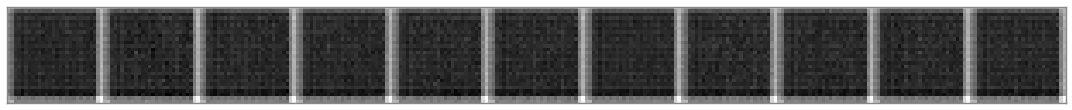

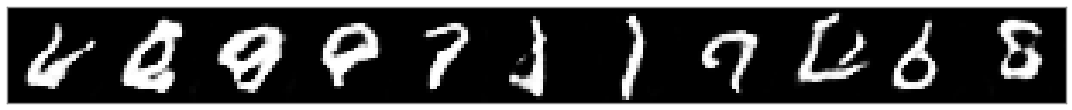

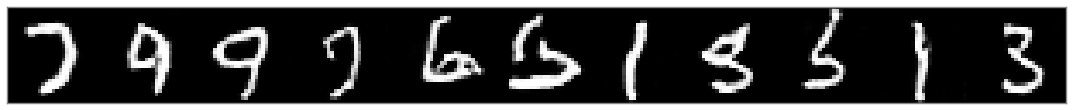

1 / 2 (50.0%)eted. Time - 112s, ETA - 0s


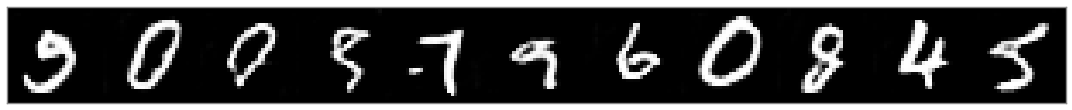

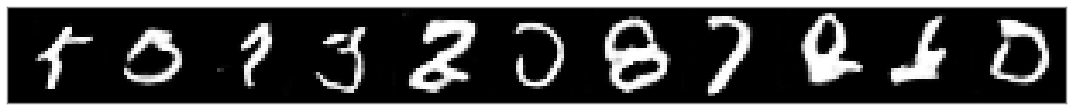

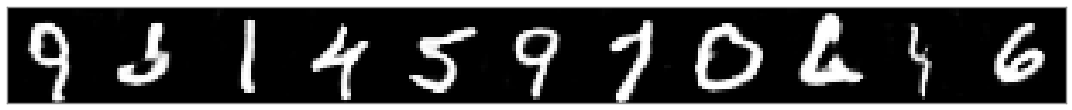

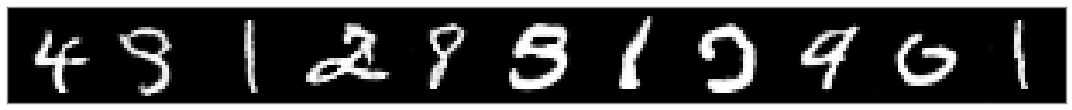

2 / 2 (100.0%)ted. Time - 113s, ETA - 0s


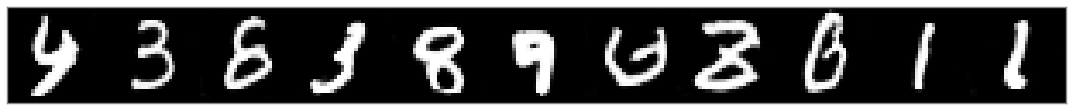

Time taken - 228.05s


In [66]:
optimize(2)

In [18]:
from utils import find_rect_factors
def plot_pdf(mean, std, pos=None):
    if pos is not None:
        mu = mean[pos][:, np.newaxis]
        sigma = np.exp(-std[pos])[:, np.newaxis]
        x = np.linspace(mu.min()-1, mu.max()+1, 1000)
        p = np.mean(np.exp(-(x-mu)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2), 0)
        #peak = np.mean(np.exp(-(np.linspace(-1, 1, n)-mu)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2), 0)
        plt.plot(x, p)
        
        for i in range(n):
            plt.plot(mu[i, 0], 1 / np.sqrt(2 * np.pi * sigma[i, 0]**2) / n, '.r', markersize=10)
            plt.plot(x, np.exp(-(x-mu[i, 0])**2 / (2 * sigma[i, 0]**2)) / np.sqrt(2 * np.pi * sigma[i, 0]**2) / n, '--')
        #plt.plot(np.linspace(-1, 1, n), peak, '.r', markersize=20)
        
        '''for i in range(n):
            width = np.linspace(-0.1, 0.1, 10) + mu[i, 0]
            height = [peak[i]] * 10
            print(mu[i, 0], sigma[i, 0])
            plt.plot(width, height, 'r')'''
        plt.show()
        return
    
    plt_shape = find_rect_factors(c_dim)
    fig, axes = plt.subplots(plt_shape[1], plt_shape[0])
    
    for i, ax in enumerate(axes.flat):
        mu = mean[i][:, np.newaxis]
        sigma = np.exp(-std[i])[:, np.newaxis]
        x = np.linspace(mu.min()-1, mu.max()+1, 1000)
        peaks = 1 / np.sqrt(2 * np.pi * sigma**2) / n
        p = np.mean(np.exp(-(x-mu)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2), 0)
        ax.plot(x, p)
        for j in range(n):
            ax.plot(np.linspace(mu[j, 0]-sigma[j, 0], mu[j, 0]+sigma[j, 0], 10), [peaks[j]]*10, 'g', alpha=0.5)
    
    plt.show()

INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Multimodal/InfoGAN-Multimodal


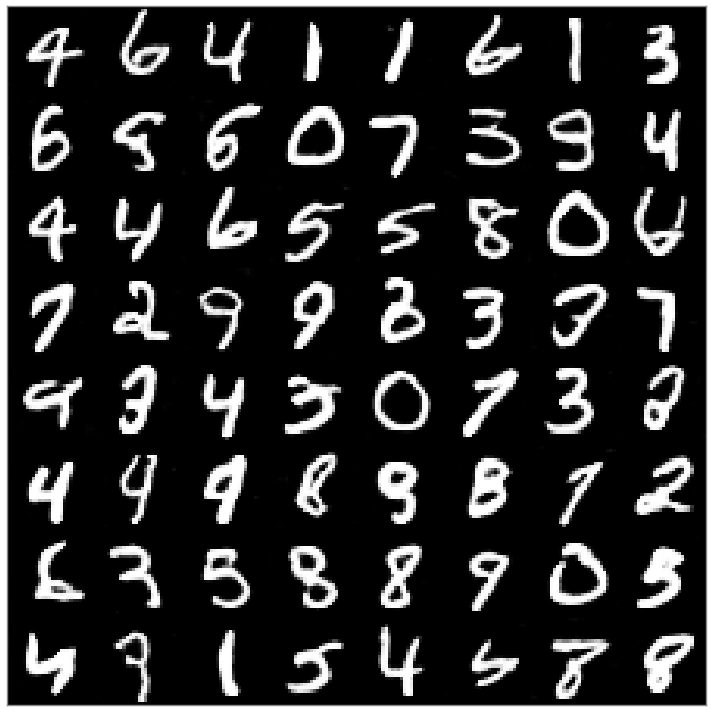

In [67]:
with tf.Session() as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())
    mu, sigma = sess.run([means, stds])
    
    plot_generated_images(sess, batch_size=64)

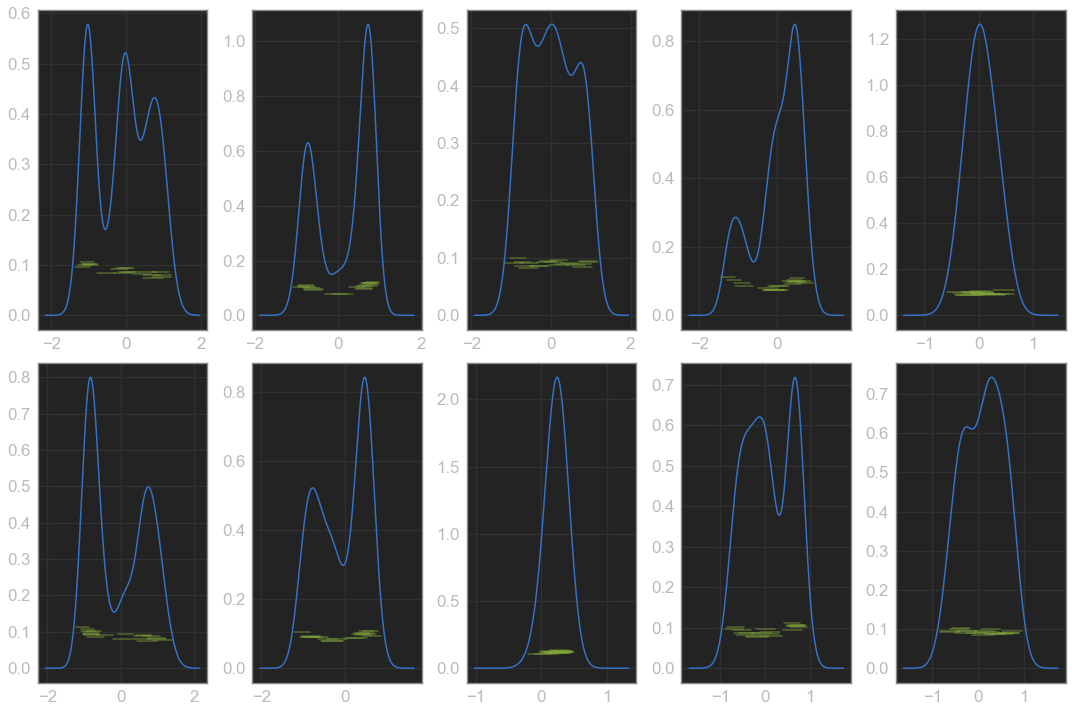

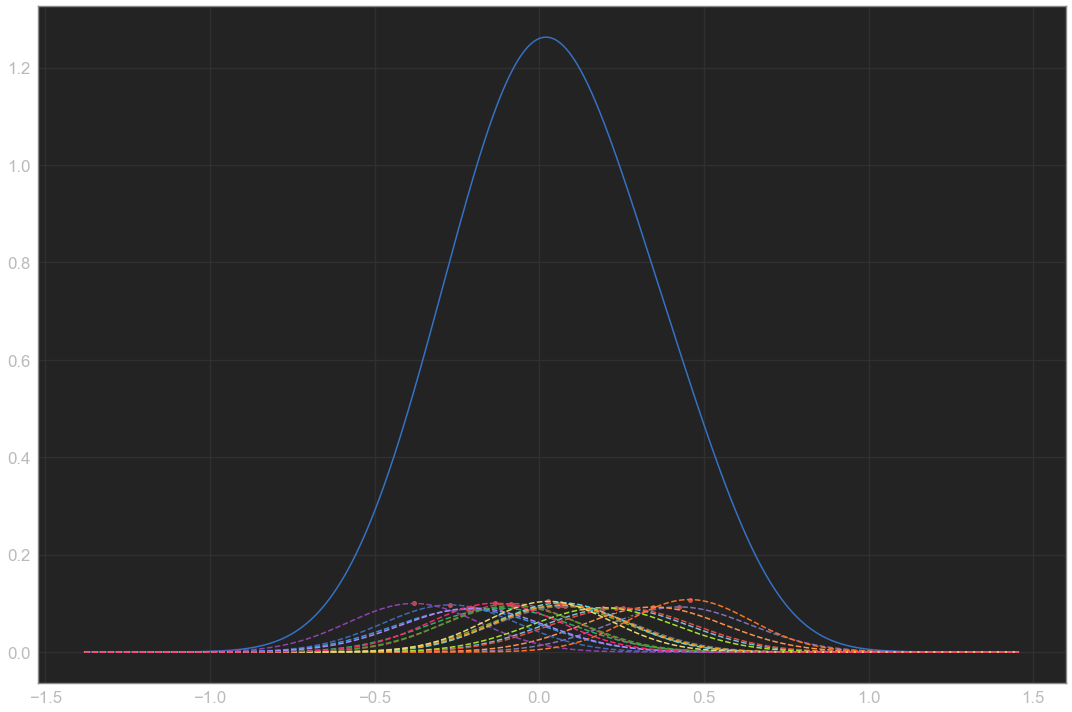

In [68]:
plot_pdf(mu, sigma)
plot_pdf(mu, sigma, 4)

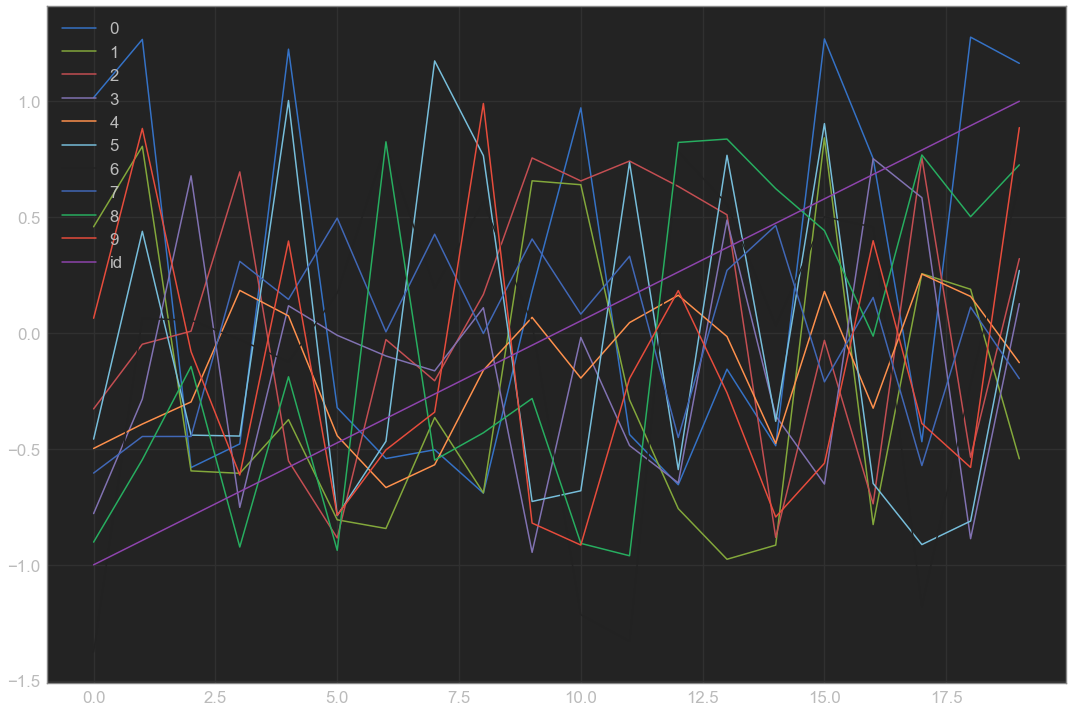

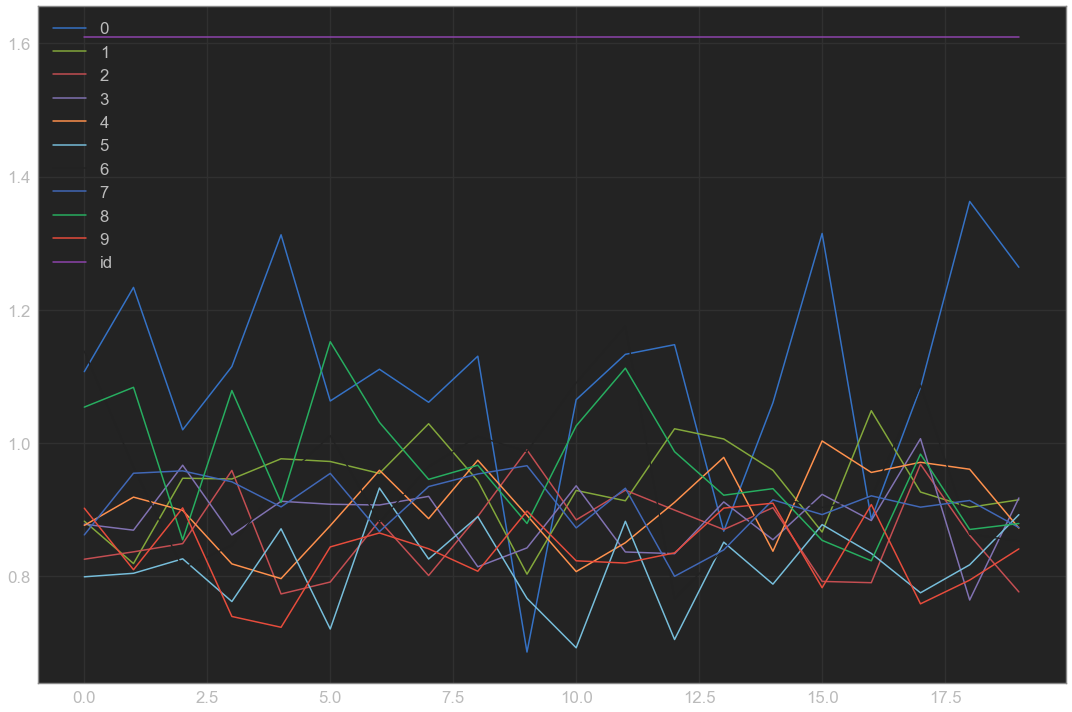

In [64]:
for i in range(c_dim):
    plt.plot(mu[i], '-', label=i)
plt.plot(np.linspace(0, 19, 10), np.linspace(-1, 1, 10), label='id')
plt.legend(loc='upper left')
plt.show()

for i in range(c_dim):
    plt.plot(sigma[i], '-', label=i)
plt.plot(np.linspace(0, 19, 10), [-np.log(0.2)]*10, label='id')
plt.legend(loc='upper left')
plt.show()

INFO:tensorflow:Restoring parameters from checkpoints/InfoGAN-Multimodal/InfoGAN-Multimodal


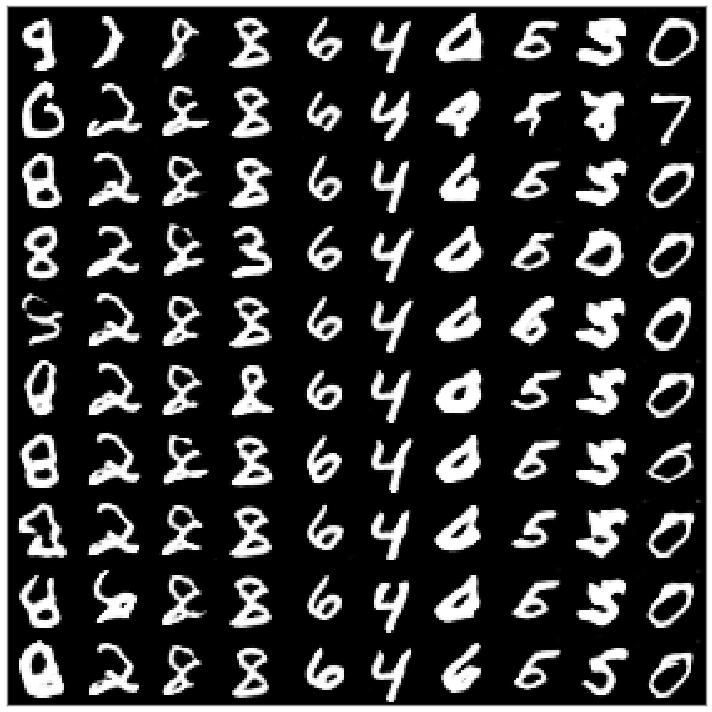

In [74]:
with tf.Session() as sess:
    if exists(path_chk_data):
        saver.restore(sess, path_chk)
    else:
        sess.run(tf.global_variables_initializer())

    latent = np.zeros((c_dim * 10, z_dim))
    latent_c = np.vstack([np.random.uniform(-1, 1, (10, c_dim))] * c_dim)
    
    for i in range(c_dim):
        latent_c[i*10:i*10+10, i] = np.linspace(-1, 1, 10)

    generated_images = sess.run(x_gen, feed_dict={c: latent_c, z: latent, training:False})

    plot_images(merge((generated_images + 1) / 2, (c_dim, 10)))

In [ ]:
%mkdir $path_out